## Temperature Control AI Model

### Import library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier, LGBMRegressor

### Data Overview

Loading & read data

In [2]:
df=pd.read_csv("dataset.csv")
df.head()

,timestamp,hour_of_day,day_of_week,day_of_year,outside_temp,outside_humidity,weather_condition,occupancy_count,is_occupied,room_temp,power_kw,fan_speed,ac_temp_setting,ac_control_reason
0,2024-01-01 00:00:00,0,0,1,24.593342,60.000000,cloudy,0.0,0,26.006587,0.0,off,NaN,SYSTEM OFF: Room unoccupied
1,2024-01-01 00:05:00,0,0,1,24.661599,60.000000,rainy,0.0,0,26.037660,0.0,off,NaN,SYSTEM OFF: Room unoccupied
2,2024-01-01 00:10:00,0,0,1,24.612982,60.000000,cloudy,0.0,0,25.949107,0.0,off,NaN,SYSTEM OFF: Room unoccupied
3,2024-01-01 00:15:00,0,0,1,24.970486,65.615747,cloudy,0.0,0,25.933911,0.0,off,NaN,SYSTEM OFF: Room unoccupied
4,2024-01-01 00:20:00,0,0,1,24.346744,62.063288,cloudy,0.0,0,25.852349,0.0,off,NaN,SYSTEM OFF: Room unoccupied


Data info

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105121 entries, 0 to 105120
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   timestamp          105121 non-null  object 
 1   hour_of_day        105121 non-null  int64  
 2   day_of_week        105121 non-null  int64  
 3   day_of_year        105121 non-null  int64  
 4   outside_temp       105121 non-null  float64
 5   outside_humidity   105121 non-null  float64
 6   weather_condition  105121 non-null  object 
 7   occupancy_count    105121 non-null  float64
 8   is_occupied        105121 non-null  int64  
 9   room_temp          105121 non-null  float64
 10  power_kw           105121 non-null  float64
 11  fan_speed          105121 non-null  object 
 12  ac_temp_setting    46119 non-null   float64
 13  ac_control_reason  105121 non-null  object 
dtypes: float64(6), int64(4), object(4)
memory usage: 11.2+ MB


Data description

In [4]:
df.describe()

,hour_of_day,day_of_week,day_of_year,outside_temp,outside_humidity,occupancy_count,is_occupied,room_temp,power_kw,ac_temp_setting
count,105121.000000,105121.000000,105121.000000,105121.000000,105121.000000,105121.000000,105121.000000,105121.000000,105121.000000,46119.000000
mean,11.499891,2.991762,183.001741,27.999405,75.823283,3.611885,0.449891,24.266641,0.696064,22.294109
std,6.922277,2.003414,105.367540,3.026859,12.949781,5.879752,0.497485,1.016505,0.786545,0.704029
min,0.000000,0.000000,1.000000,21.941441,60.000000,0.000000,0.000000,22.299940,0.000000,20.000000
25%,5.000000,1.000000,92.000000,25.432435,61.944477,0.000000,0.000000,23.490140,0.000000,22.000000
50%,11.000000,3.000000,183.000000,28.001006,75.003321,0.000000,0.000000,24.000350,0.000000,22.000000
75%,17.000000,5.000000,274.000000,30.565238,88.059324,5.000000,1.000000,24.809658,1.600000,23.000000
max,23.000000,6.000000,366.000000,34.087714,95.000000,20.000000,1.000000,29.858400,1.700000,23.000000


Check total missing values

In [5]:
df.isnull().sum()

timestamp                0
hour_of_day              0
day_of_week              0
day_of_year              0
outside_temp             0
outside_humidity         0
weather_condition        0
occupancy_count          0
is_occupied              0
room_temp                0
power_kw                 0
fan_speed                0
ac_temp_setting      59002
ac_control_reason        0
dtype: int64

Analyze the value counts of key features

In [6]:
print("power_kw:", df['power_kw'].value_counts().to_dict())
print("fan_speed:", df['fan_speed'].value_counts().to_dict())
print("ac_temp_setting:", df['ac_temp_setting'].value_counts().to_dict())


power_kw: {0.0: 57828, 1.6: 25913, 1.55: 17992, 1.7: 2214, 0.05: 1174}
fan_speed: {'off': 57828, 'medium': 25913, 'low': 19166, 'high': 2214}
ac_temp_setting: {22.0: 25913, 23.0: 17992, 20.0: 2214}


### Visualisation

In [7]:
numerical_data = df.select_dtypes(include=[np.number])
categorical_data = ['weather_condition', 'fan_speed', 'ac_control_reason']

Visualize categorical data

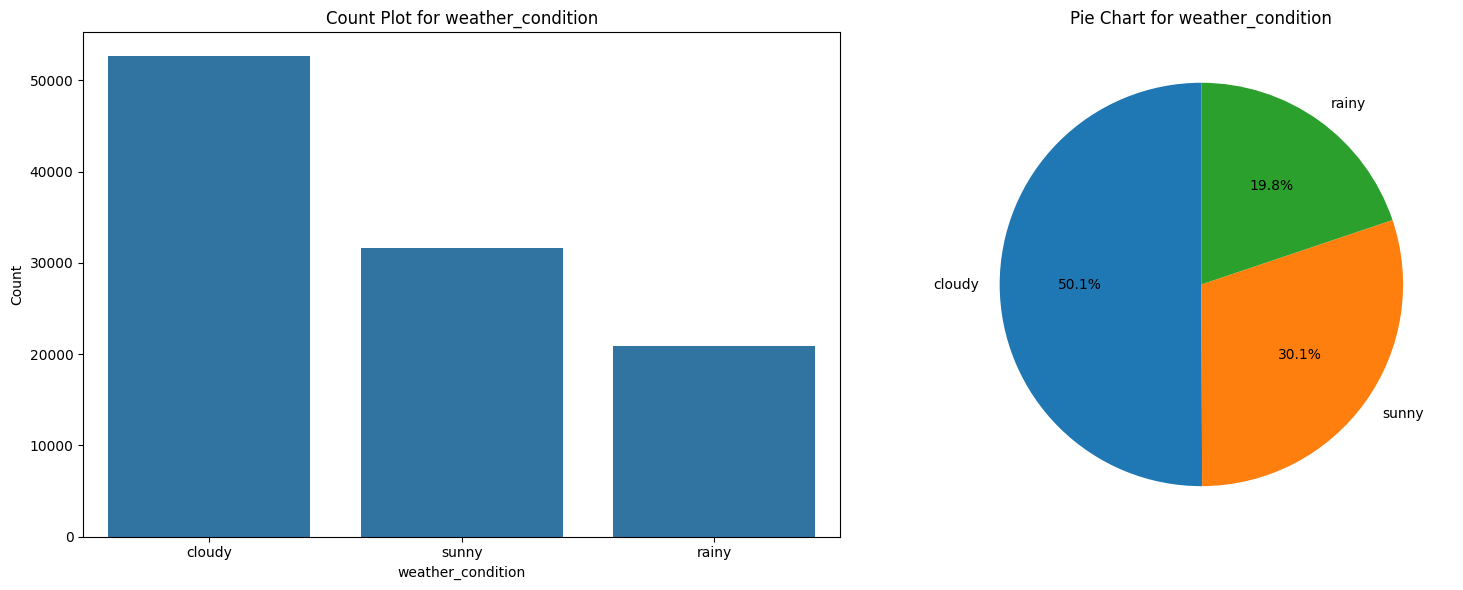

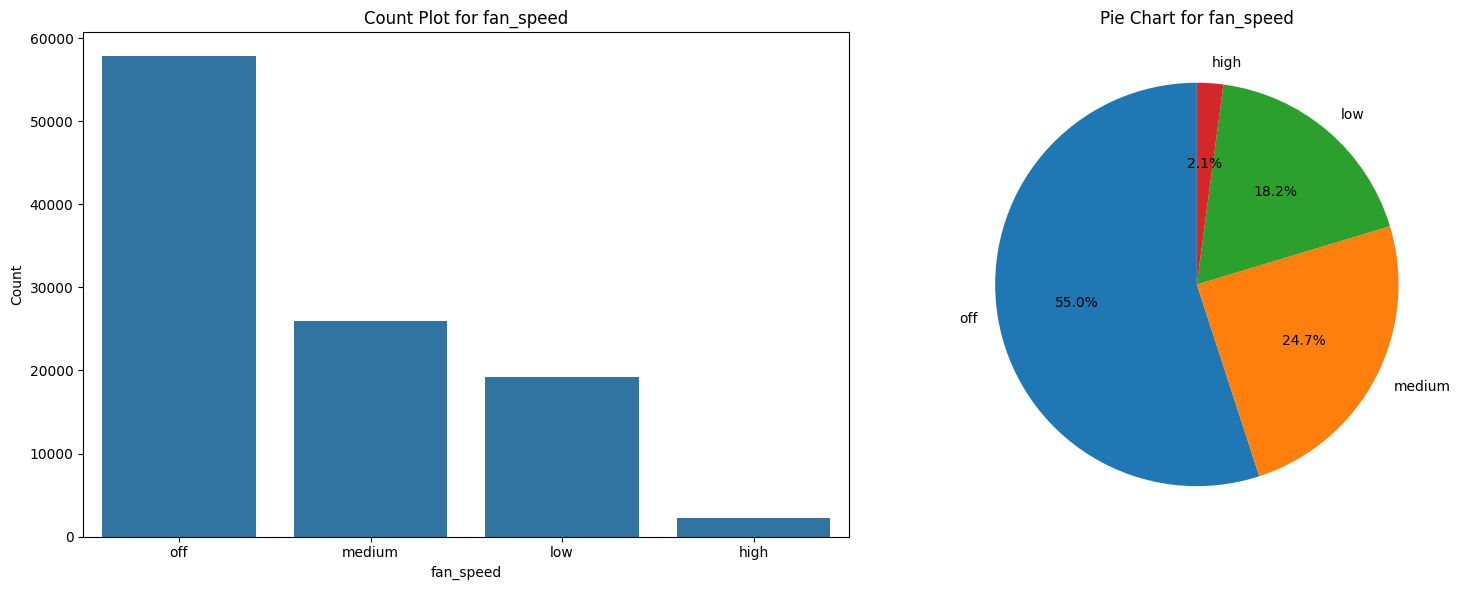

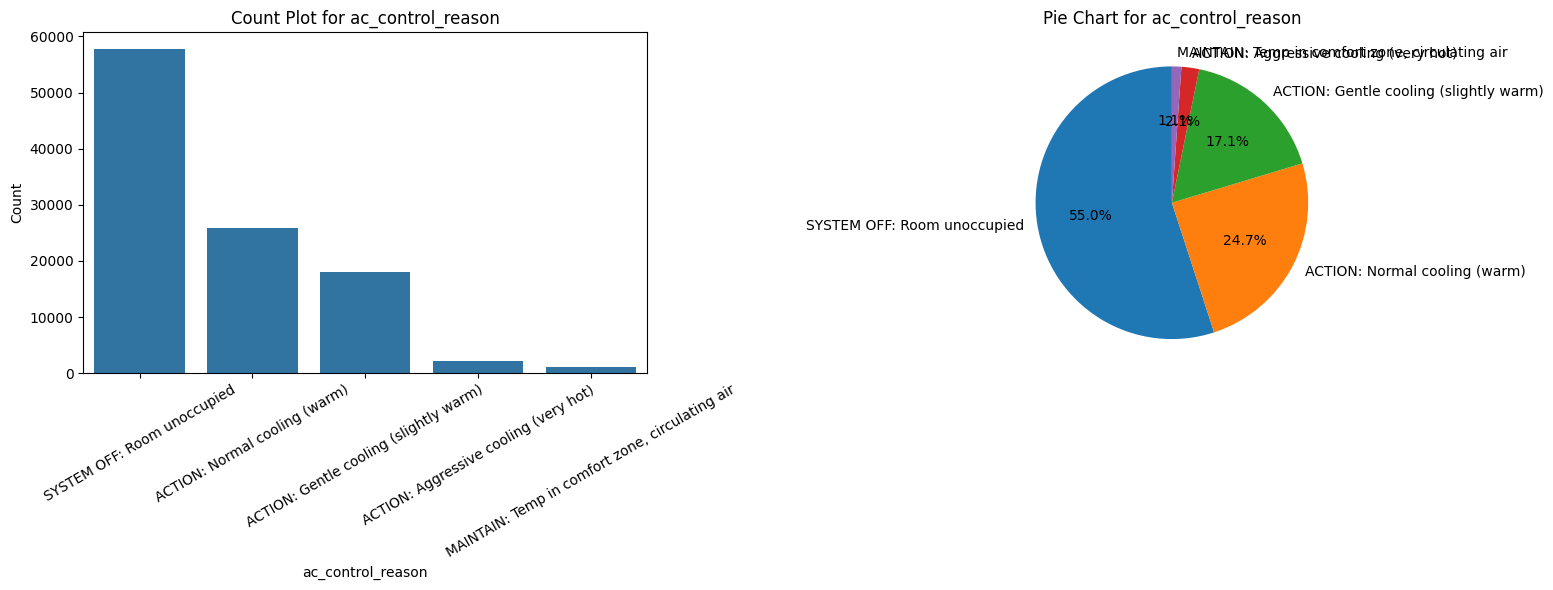

In [8]:
for feature in categorical_data:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.countplot(x=feature, data=df, order=df[feature].value_counts().index, ax=axes[0])
    axes[0].set_title(f'Count Plot for {feature}')
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel('Count')

    counts = df[feature].value_counts()
    axes[1].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axes[1].set_title(f'Pie Chart for {feature}')

    if feature == 'ac_control_reason':
        axes[0].tick_params(axis='x', rotation=30)

    plt.tight_layout()
    plt.show()

Visualize numerical data

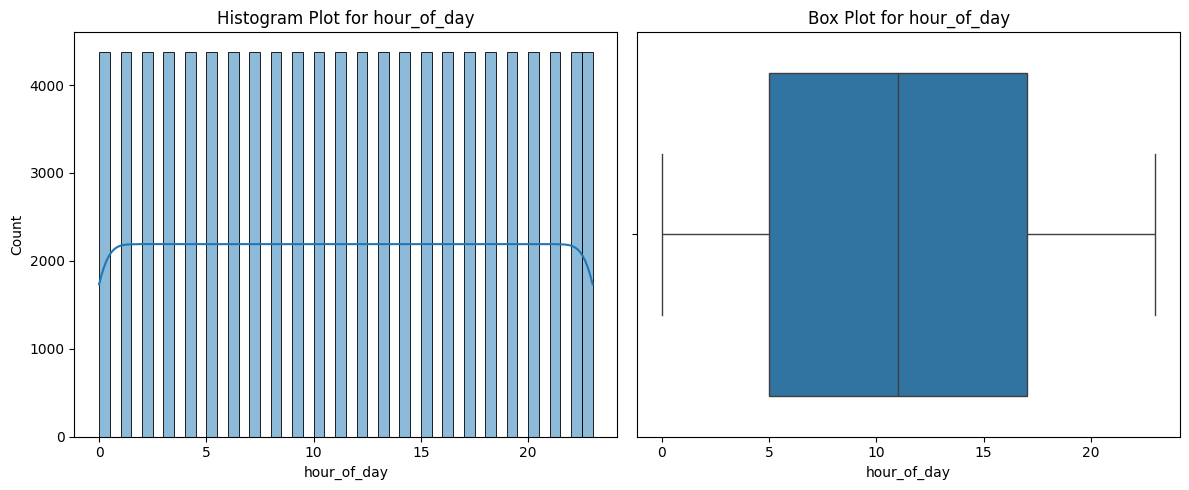

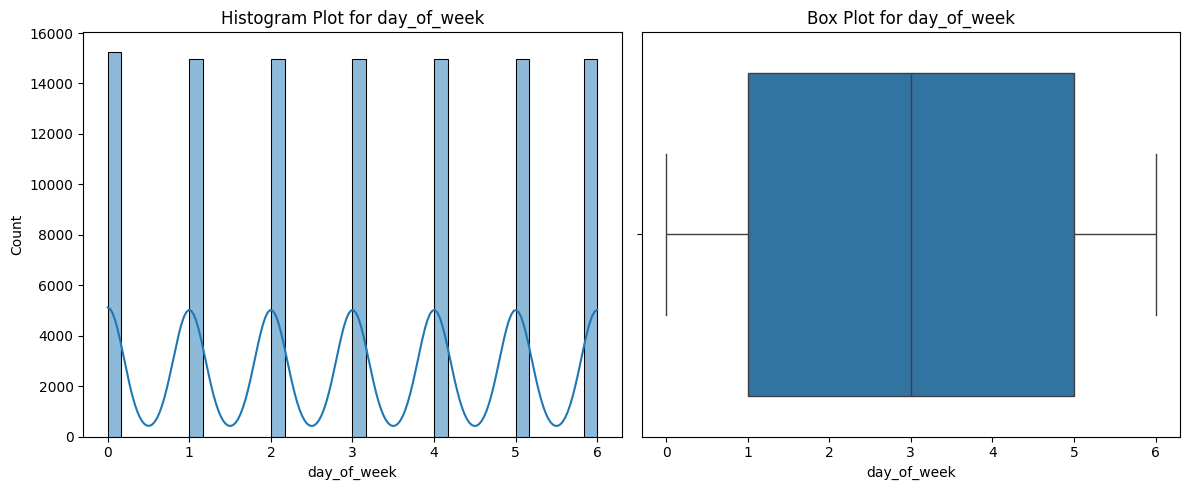

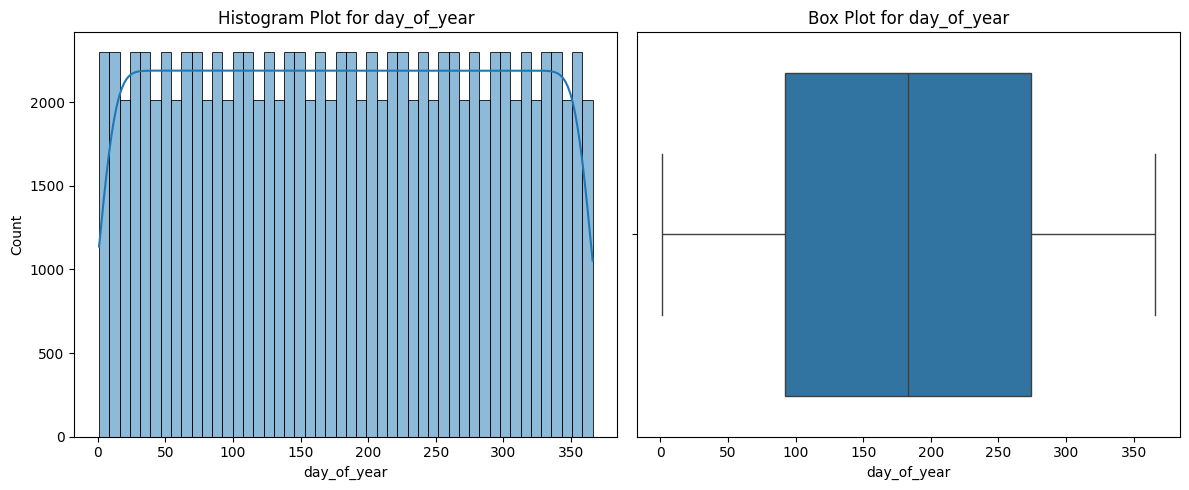

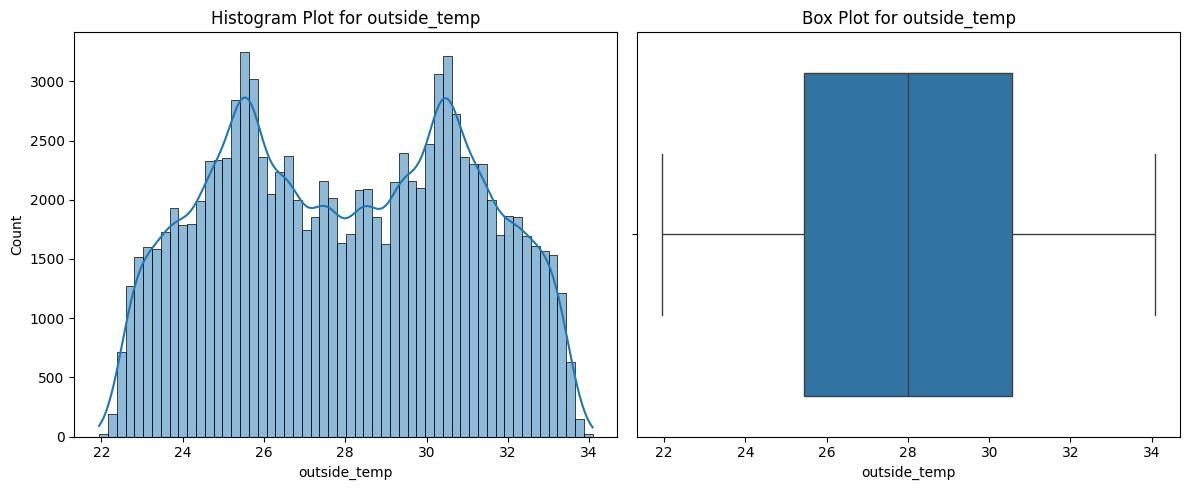

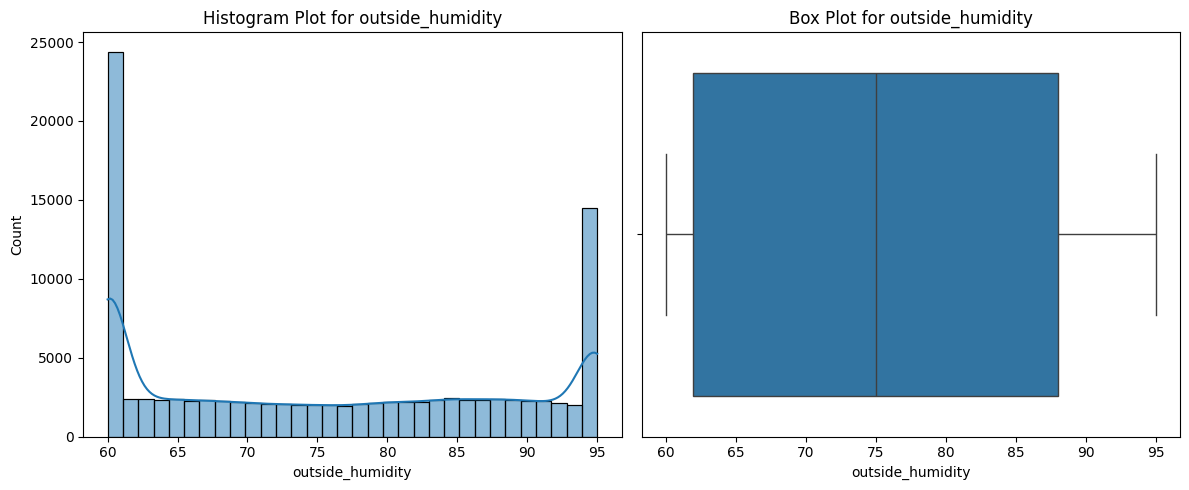

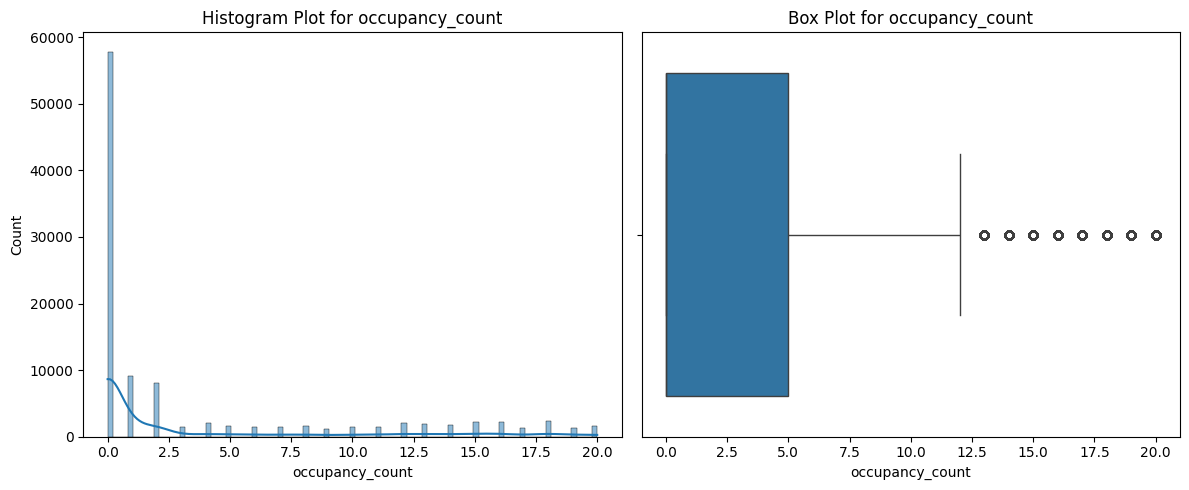

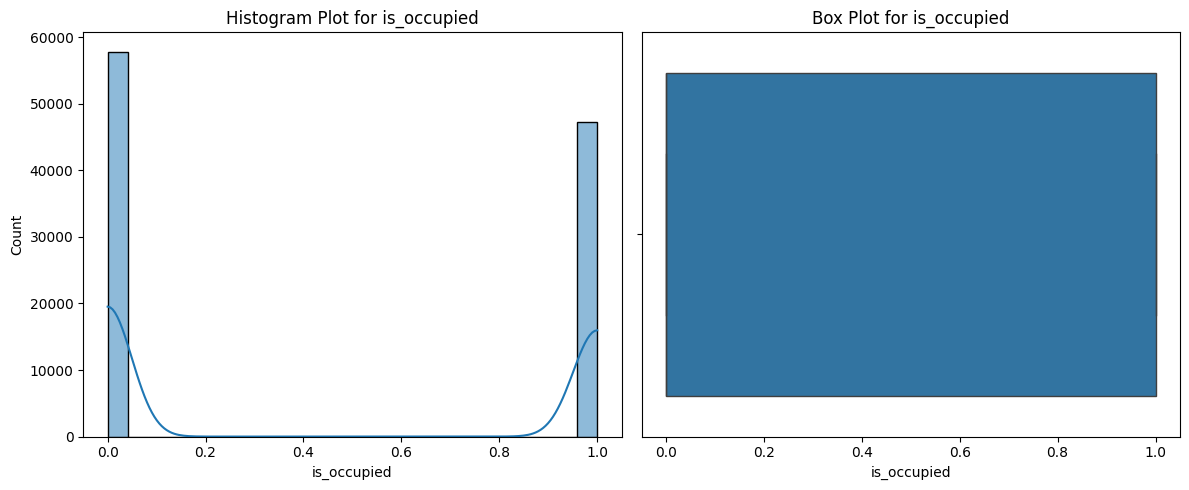

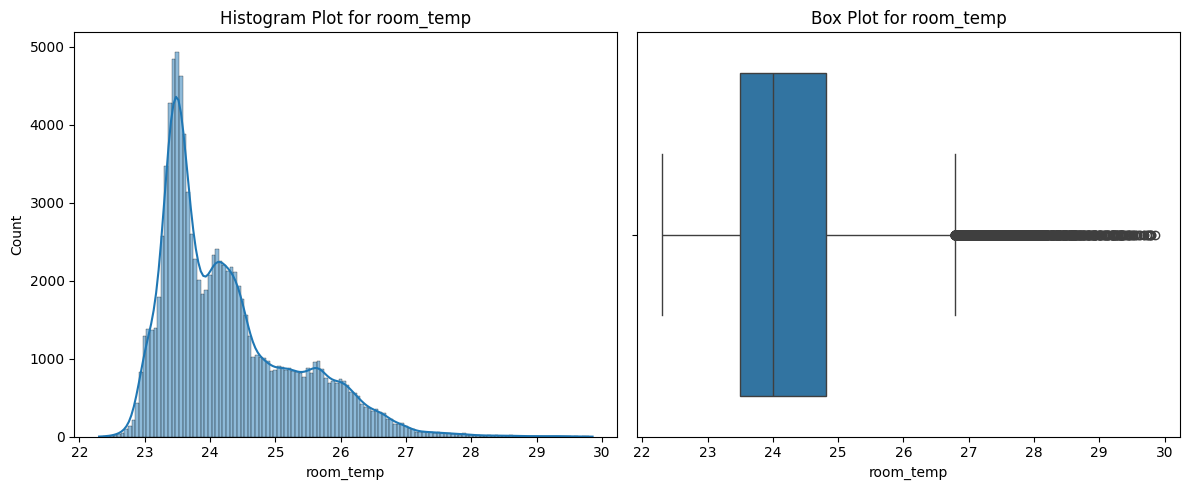

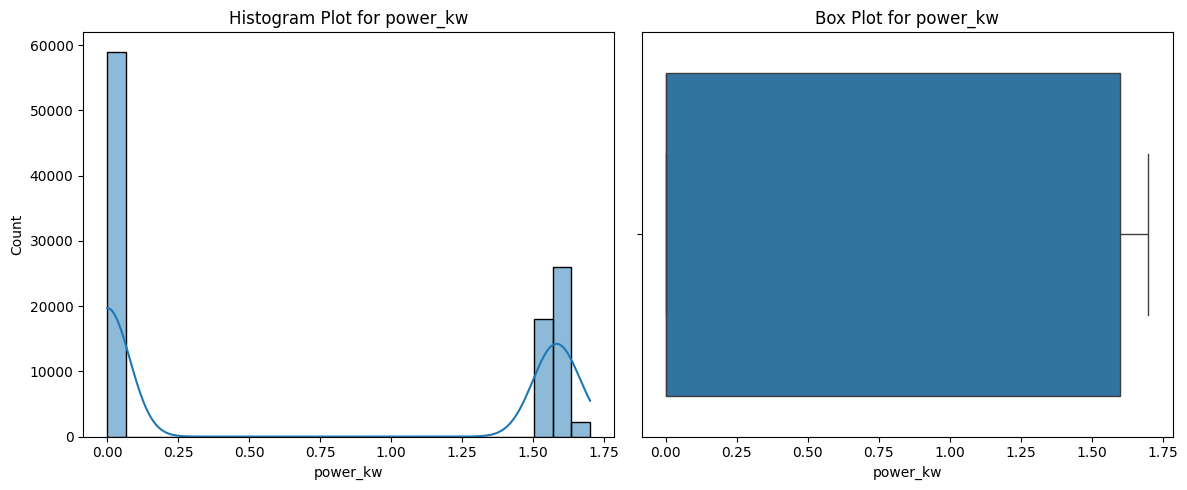

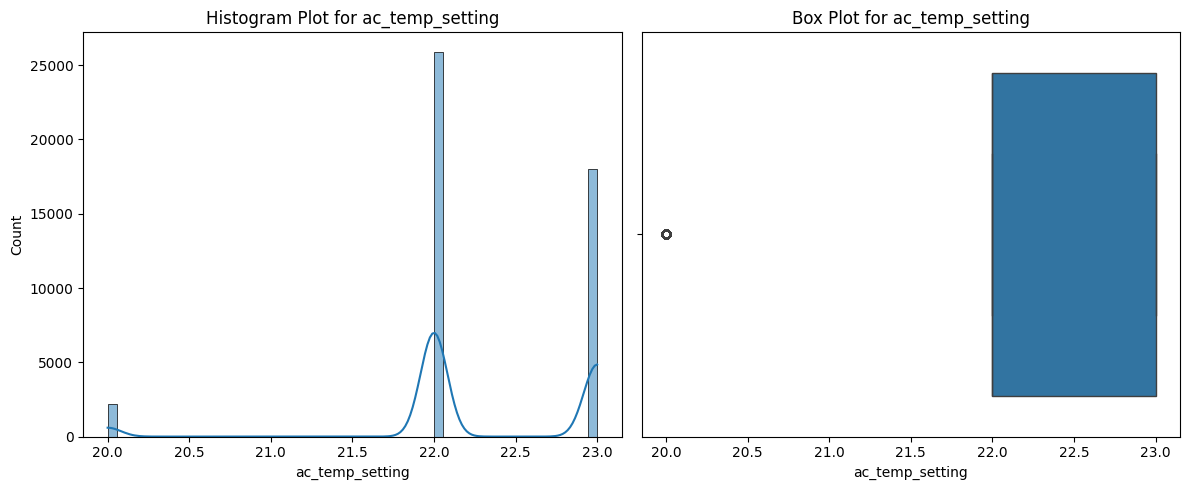

In [9]:
for feature in numerical_data:
    fig, axes = plt.subplots(1,2, figsize = (12, 5))
    sns.histplot(data=df, x=feature, kde=True, ax=axes[0])
    sns.boxplot(data=df, x=feature, ax=axes[1])
    axes[0].set_title(f'Histogram Plot for {feature}')
    axes[1].set_title(f'Box Plot for {feature}')

    plt.tight_layout()
    plt.show()

### Data Preprocessing & Feature Engineering

Create new features by extracting timestamp for peak hour

In [10]:
df["hour"] = pd.to_datetime(df["timestamp"]).dt.hour
df["dayofweek"] = pd.to_datetime(df["timestamp"]).dt.dayofweek
df["is_peak_hour"] = df["hour"].between(12, 17).astype(int)

Impute ac_temp_setting for rows where the AC is on with the mean

In [11]:
mask_ac_on = (df["power_kw"] > 0) & (df["fan_speed"] != "off")
df.loc[mask_ac_on, "ac_temp_setting"] = df.loc[mask_ac_on, "ac_temp_setting"].fillna(
    df.loc[mask_ac_on, "ac_temp_setting"].mean()
)

Convert the categorical fan_speed to a numerical format based on alphabetical order
{0:high, 1:low, 2:medium, 3:off, 4:on}

In [12]:
fan_encoder = LabelEncoder()
df["fan_speed_encoded"] = fan_encoder.fit_transform(df["fan_speed"])

Cyclical temporal features

In [13]:
# This helps the model understand the cyclical nature of hours and days.
df.loc[:, 'hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24.0)
df.loc[:, 'hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24.0)
df.loc[:, 'dayofweek_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7.0)
df.loc[:, 'dayofweek_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7.0)

Drop rows with any remaining missing values in key columns

In [14]:
df = df.dropna(subset=["ac_temp_setting", "fan_speed", "power_kw"])

Calculate the difference between room and outside temperature

In [15]:
df.loc[:, 'temp_diff'] = df['room_temp'] - df['outside_temp']

Impute ac_temp_setting before calculating the set point difference

In [16]:
mask_ac_on = (df["power_kw"] > 0) & (df["fan_speed"] != "off")
mean_ac_temp = df.loc[mask_ac_on, "ac_temp_setting"].mean()
df.loc[mask_ac_on, "ac_temp_setting"] = df.loc[mask_ac_on, "ac_temp_setting"].fillna(mean_ac_temp)

Calculate the difference to the target temperature

In [17]:
df.loc[:, 'set_point_diff'] = df['room_temp'] - df['ac_temp_setting']
df.loc[:, 'set_point_diff'] = df['set_point_diff'].fillna(0)

Drop unuse columns

In [18]:
columns_to_drop = [
    'day_of_year',
    'occupancy_count',
    'is_occupied',
    'outside_humidity',
    'timestamp',
    'hour_of_day',
    'day_of_week',
    'ac_control_reason'
]
df.drop(columns=columns_to_drop, axis=1, inplace=True)

### Model Training & Evaluation

Separate the data into features (X) and target variables (y)

In [19]:
columns_to_use = ['room_temp', 'outside_temp', 'weather_condition', 'is_peak_hour',
                  'temp_diff', 'set_point_diff', 'hour_sin', 'hour_cos',
                  'dayofweek_sin', 'dayofweek_cos']
X = df[columns_to_use]
y_fan = df["fan_speed_encoded"]
y_temp = df["ac_temp_setting"]
y_power = df["power_kw"]

Split the data into training and testing sets

In [20]:
X_train, X_test, y_fan_train, y_fan_test, y_temp_train, y_temp_test, y_power_train, y_power_test = train_test_split(
    X, y_fan, y_temp, y_power, test_size=0.3, random_state=42
)

Create a preprocessor for numerical and categorical features

In [21]:
numeric_features = ['room_temp', 'outside_temp', 'temp_diff', 'set_point_diff',
                    'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos','is_peak_hour']

categorical_features = ['weather_condition']

Preprocessor applies StandardScaler to numerical features and OneHotEncoder to categorical features.

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

Train models

In [23]:
models = {}

# 1. Fan speed (classification) with GridSearchCV
# Create a pipeline for the fan speed classification model
fan_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])
fan_param_grid = {
    'clf__n_estimators': [1, 5, 10],
    'clf__max_depth': [None, 1, 2],
}
# Use GridSearchCV to find the best hyperparameters for the fan speed model
fan_grid_search = GridSearchCV(fan_pipeline, fan_param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
fan_grid_search.fit(X_train, y_fan_train)
best_fan_model = fan_grid_search.best_estimator_
y_fan_pred = best_fan_model.predict(X_test)
print("FAN SPEED MODEL")
print("Accuracy:", accuracy_score(y_fan_test, y_fan_pred))
print("F1 Score:", f1_score(y_fan_test, y_fan_pred, average="weighted"))
models["fan"] = best_fan_model

# 2. AC temperature (regression) with GridSearchCV
# Create a pipeline for the AC temperature regression model
temp_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("reg", RandomForestRegressor(random_state=42))
])
temp_param_grid = {
    'reg__n_estimators': [5, 10, 30],
    'reg__max_depth': [None, 1, 3],
}
# Use GridSearchCV to find the best hyperparameters for the AC temperature model
temp_grid_search = GridSearchCV(temp_pipeline, temp_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
temp_grid_search.fit(X_train, y_temp_train)
best_temp_model = temp_grid_search.best_estimator_
y_temp_pred = best_temp_model.predict(X_test)
print("\nAC TEMP MODEL")
print("RMSE:", np.sqrt(mean_squared_error(y_temp_test, y_temp_pred)))
print("R²:", r2_score(y_temp_test, y_temp_pred), "\n")
models["temp"] = best_temp_model

# 3. Power consumption (regression) with GridSearchCV
# Create a pipeline for the power consumption regression model
power_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("reg", LGBMRegressor(random_state=42))
])
# Define the hyperparameter grid
power_param_grid = {
    'reg__learning_rate': [0.01, 0.05],
    'reg__n_estimators': [300, 800],
    'reg__num_leaves': [25, 40]
}
# Use GridSearchCV to find the best hyperparameters for the power consumption model
power_grid_search = GridSearchCV(power_pipeline, power_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
power_grid_search.fit(X_train, y_power_train)
best_power_model = power_grid_search.best_estimator_
y_power_pred = best_power_model.predict(X_test)
print("\nPOWER MODEL")
print("RMSE:", np.sqrt(mean_squared_error(y_power_test, y_power_pred)))
print("R²:", r2_score(y_power_test, y_power_pred))
models["power"] = best_power_model

print("\nAll models have been trained and tuned successfully.")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
FAN SPEED MODEL
Accuracy: 0.9999295179024528
F1 Score: 0.999929541864823
Fitting 5 folds for each of 9 candidates, totalling 45 fits

AC TEMP MODEL
RMSE: 0.0023704850419352073
R²: 0.9999884409470046 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 33105, number of used features: 12
[LightGBM] [Info] Start training from score 1.548017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

C:\Users\allyv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



POWER MODEL
RMSE: 0.03125434962233065
R²: 0.9840074780487902

All models have been trained and tuned successfully.


### Data Explainability


--- SHAP Explanations for Fan Speed Model ---

Global Feature Impact (Summary Plot):


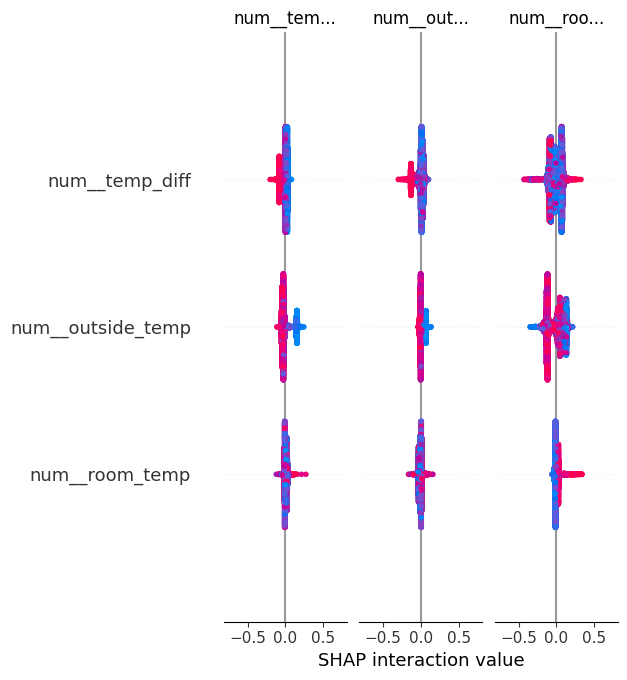


Local Explanation for Prediction #0 (Waterfall Plot):


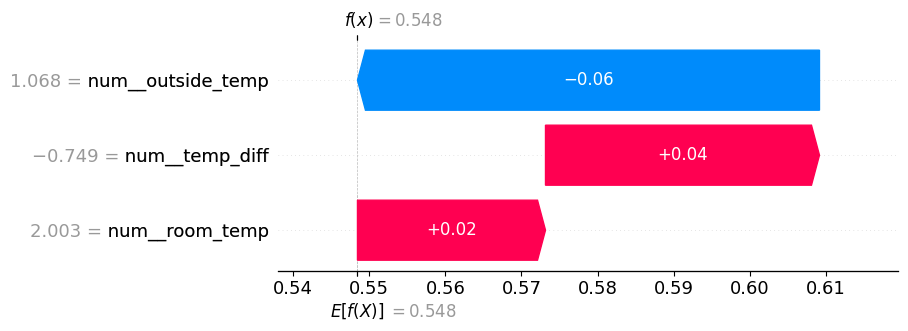


--- SHAP Explanations for AC Temp Model ---

Global Feature Impact (Summary Plot):


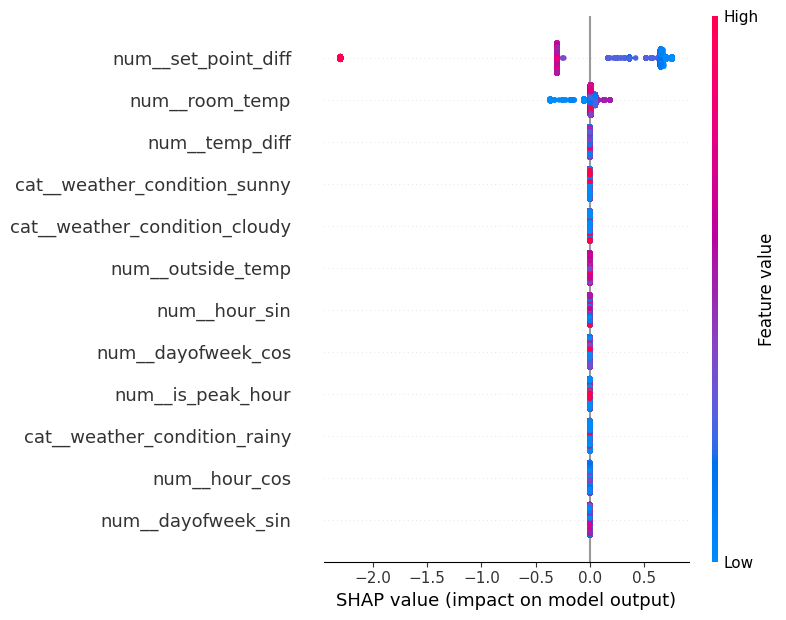


Local Explanation for Prediction #0 (Waterfall Plot):


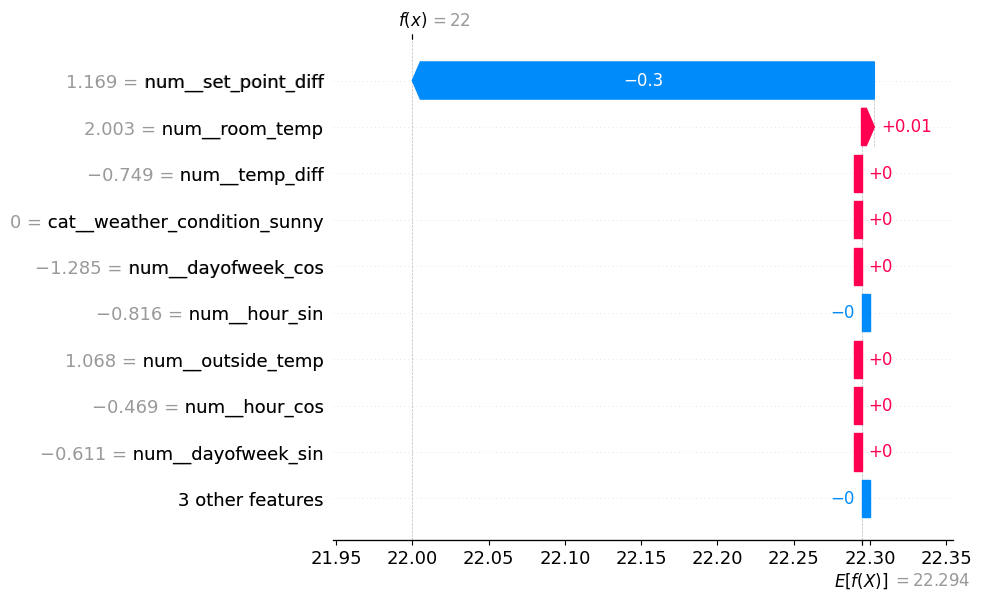


--- SHAP Explanations for Power Model ---

Global Feature Impact (Summary Plot):


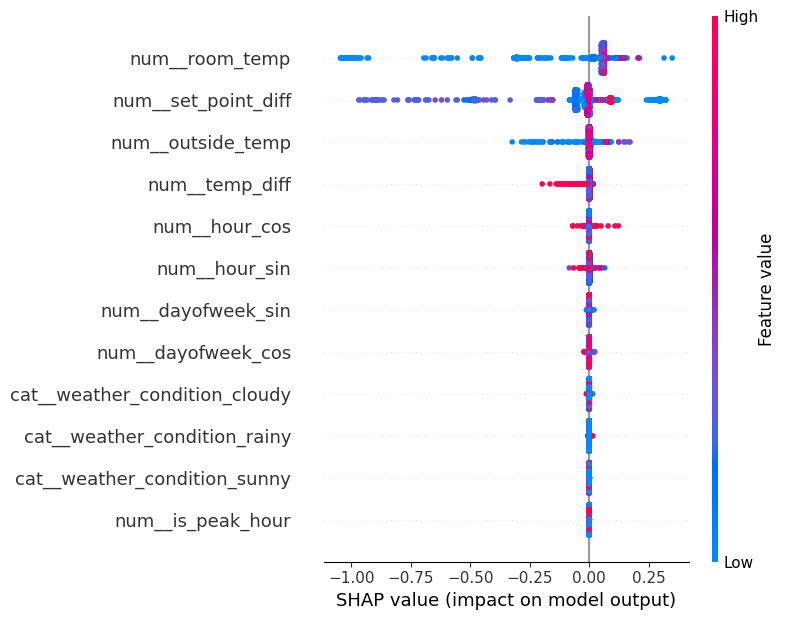


Local Explanation for Prediction #0 (Waterfall Plot):


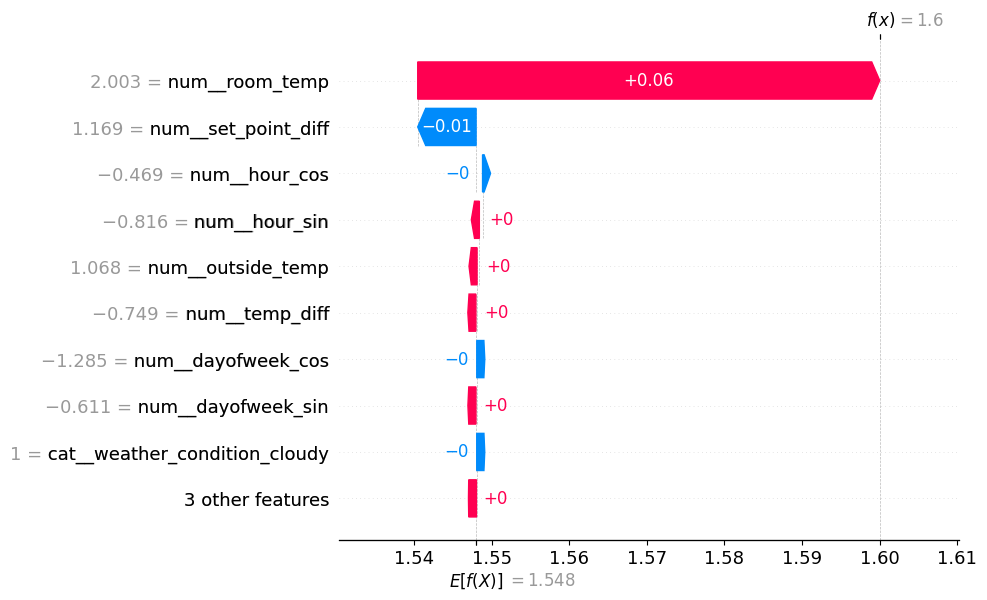

In [24]:
# SHAP Model Explanations

# Get the feature names after preprocessing
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

# Get the preprocessed data for the test set
X_test_preprocessed = preprocessor.transform(X_test)

# Convert preprocessed data to a DataFrame for clear plotting
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

# --- FAN SPEED MODEL (CLASSIFICATION) ---
print("\n--- SHAP Explanations for Fan Speed Model ---")
trained_fan_clf = best_fan_model.named_steps['clf']
# SHAP TreeExplainer for the Random Forest Classifier
explainer_fan = shap.TreeExplainer(trained_fan_clf)
# shap_values_fan is a list for multi-class classifiers
shap_values_fan = explainer_fan.shap_values(X_test_preprocessed_df)

# Plot a SHAP summary plot for overall feature impact
print("\nGlobal Feature Impact (Summary Plot):")
shap.initjs()
# The summary plot for multi-class models takes a list of SHAP values
shap.summary_plot(shap_values_fan, X_test_preprocessed_df)

# Plot a SHAP waterfall plot for a single prediction
instance_index = 0
print(f"\nLocal Explanation for Prediction #{instance_index} (Waterfall Plot):")
shap.initjs()
# To get the values for a single instance, we need to access the appropriate class's values
shap_values_instance = shap_values_fan[y_fan_pred[instance_index]][instance_index]
shap.waterfall_plot(shap.Explanation(
    values=shap_values_instance,
    base_values=explainer_fan.expected_value[y_fan_pred[instance_index]],
    data=X_test_preprocessed_df.iloc[instance_index],
    feature_names=feature_names
))

# --- AC TEMP MODEL (REGRESSION) ---
print("\n--- SHAP Explanations for AC Temp Model ---")
trained_temp_reg = best_temp_model.named_steps['reg']
# SHAP TreeExplainer for the Random Forest Regressor
explainer_temp = shap.TreeExplainer(trained_temp_reg)
shap_values_temp = explainer_temp.shap_values(X_test_preprocessed_df)

# Plot a SHAP summary plot
print("\nGlobal Feature Impact (Summary Plot):")
shap.initjs()
shap.summary_plot(shap_values_temp, X_test_preprocessed_df)

# Plot a SHAP waterfall plot for a single prediction
print(f"\nLocal Explanation for Prediction #{instance_index} (Waterfall Plot):")
shap.initjs()
shap.waterfall_plot(shap.Explanation(
    values=shap_values_temp[instance_index],
    base_values=explainer_temp.expected_value,
    data=X_test_preprocessed_df.iloc[instance_index],
    feature_names=feature_names
))

# --- POWER MODEL (REGRESSION) ---
print("\n--- SHAP Explanations for Power Model ---")
trained_power_reg = best_power_model.named_steps['reg']
# SHAP TreeExplainer for the LightGBM Regressor
explainer_power = shap.TreeExplainer(trained_power_reg)
shap_values_power = explainer_power.shap_values(X_test_preprocessed_df)

# Plot a SHAP summary plot
print("\nGlobal Feature Impact (Summary Plot):")
shap.initjs()
shap.summary_plot(shap_values_power, X_test_preprocessed_df)

# Plot a SHAP waterfall plot for a single prediction
print(f"\nLocal Explanation for Prediction #{instance_index} (Waterfall Plot):")
shap.initjs()
shap.waterfall_plot(shap.Explanation(
    values=shap_values_power[instance_index],
    base_values=explainer_power.expected_value,
    data=X_test_preprocessed_df.iloc[instance_index],
    feature_names=feature_names
))

### Deploy AI Model

In [25]:
# The best models stored in dictionary
best_fan_model = models["fan"]
best_temp_model = models["temp"]
best_power_model = models["power"]

# Save the models to files
joblib.dump(best_fan_model, 'best_fan_model.joblib')
joblib.dump(best_temp_model, 'best_temp_model.joblib')
joblib.dump(best_power_model, 'best_power_model.joblib')

print("Models saved successfully.")

Models saved successfully.


In [26]:
# Load the trained models from their files
loaded_fan_model = joblib.load('best_fan_model.joblib')
loaded_temp_model = joblib.load('best_temp_model.joblib')
loaded_power_model = joblib.load('best_power_model.joblib')

# Load the new data for prediction from the new CSV file (Only 5 rows & generated by Google Gemini)
new_data = pd.read_csv("testing_data.csv")

# Make predictions for each model on the same new data
fan_prediction = loaded_fan_model.predict(new_data)
temp_prediction = loaded_temp_model.predict(new_data)
power_prediction = loaded_power_model.predict(new_data)

print("New Fan Speed Predictions {0:high, 1:low, 2:medium, 3:off, 4:on}:", fan_prediction)
print("New AC Temperature Predictions:", temp_prediction)
print("New Power Consumption Predictions:", power_prediction)

New Fan Speed Predictions {0:high, 1:low, 2:medium, 3:off, 4:on}: [1 2 1 1 2]
New AC Temperature Predictions: [23. 22. 23. 23. 22.]
New Power Consumption Predictions: [1.54924153 1.57909569 1.07031787 1.55151238 1.58543521]


C:\Users\allyv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
